In [15]:
# -*- coding: utf-8 -*-
#  Copyright 2024 -  United Kingdom Research and Innovation
#  Copyright 2024 -  The University of Manchester
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    CIL contributors 

# CIL Callback demonstration

This notebook runs on CIL Master (built on 14/03/2024) and demonstrates the new callback functionality 

In [16]:
from cil.utilities import dataexample
from cil.utilities.display import show2D
from cil.recon import FDK
from cil.processors import TransmissionAbsorptionConverter, Slicer
from cil.utilities.quality_measures import psnr
import numpy as np
import matplotlib.pyplot as plt 
from cil.plugins.tigre import ProjectionOperator
from cil.optimisation.algorithms import FISTA, Algorithm
from cil.optimisation.functions import LeastSquares, IndicatorBox, ZeroFunction, TotalVariation
from cil.optimisation.operators import GradientOperator
from cil.optimisation.utilities import callbacks
from cil.framework import DataContainer

from cil.utilities.quality_measures import mse, mae, psnr

# set up default colour map for visualisation
cmap = "gray"

# set the backend for FBP and the ProjectionOperator
device = 'gpu'



## Load Data 

FDK recon

Input Data:
	angle: 60
	horizontal: 128

Reconstruction Volume:
	horizontal_y: 128
	horizontal_x: 128

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 8
	Filter_inplace: False



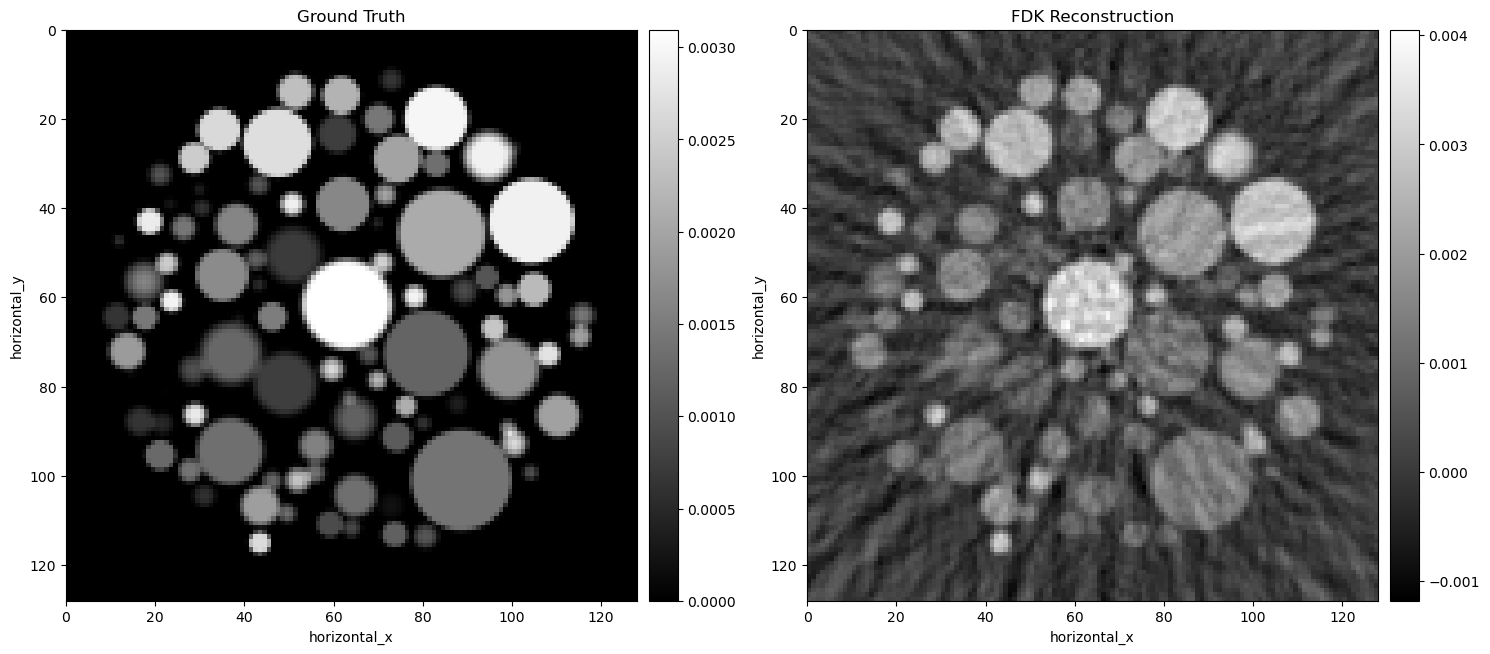

In [17]:

#%% Load data
ground_truth = dataexample.SIMULATED_SPHERE_VOLUME.get()

data = dataexample.SIMULATED_CONE_BEAM_DATA.get()
twoD = True
if twoD:
    data = data.get_slice(vertical='centre')
    ground_truth = ground_truth.get_slice(vertical='centre')

absorption = TransmissionAbsorptionConverter()(data)
absorption = Slicer(roi={'angle':(0, -1, 5)})(absorption)

ig = ground_truth.geometry

#%%
recon = FDK(absorption, image_geometry=ig).run()
#%%
show2D([ground_truth, recon], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2)

# %%


## Default behaviour 

  0%|          | 0/500 [00:00<?, ?it/s]

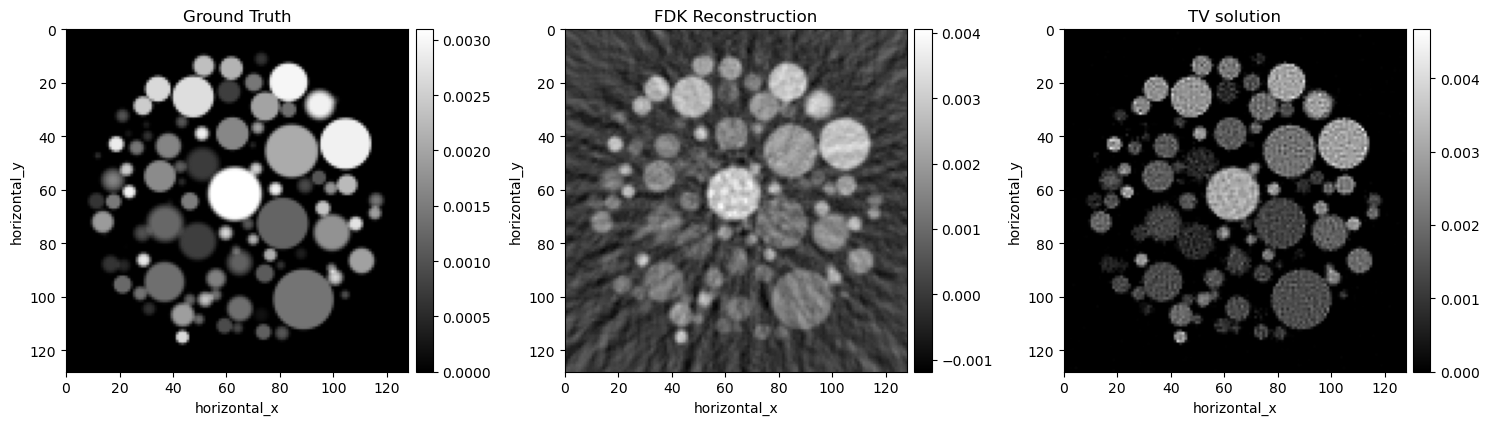

In [18]:


alpha=0.1
A = ProjectionOperator(image_geometry=ig, 
                       acquisition_geometry=absorption.geometry)

F = LeastSquares(A = A, b = absorption)
G = alpha*TotalVariation(lower=0)

algo=FISTA(initial=ig.allocate(0), f=F, g=G)
algo.run(500)
show2D([ground_truth, recon, algo.solution], title = ['Ground Truth', 'FDK Reconstruction', 'TV solution'], origin = 'upper', num_cols = 3)


## Other provided CIL callbacks 

  0%|          | 0/500 [00:00<?, ?it/s]

     0/500        ?it/s
    10/500    29.53it/s, objective=+8.586e+01
    20/500    29.53it/s, objective=+9.047e+00
    30/500    28.65it/s, objective=+2.640e+00
    40/500    28.53it/s, objective=+1.188e+00
    50/500    18.75it/s, objective=+6.928e-01
    60/500    21.45it/s, objective=+4.585e-01
    70/500    23.55it/s, objective=+3.451e-01
    80/500    25.28it/s, objective=+2.741e-01
    90/500    26.58it/s, objective=+2.337e-01
   100/500    27.57it/s, objective=+2.062e-01
   110/500    28.17it/s, objective=+1.870e-01
   120/500    20.05it/s, objective=+1.729e-01
   130/500    22.35it/s, objective=+1.623e-01
   140/500    24.32it/s, objective=+1.541e-01
   150/500    25.89it/s, objective=+1.476e-01
   160/500    26.91it/s, objective=+1.421e-01
   170/500    27.82it/s, objective=+1.375e-01
   180/500    28.58it/s, objective=+1.336e-01
   190/500    20.24it/s, objective=+1.303e-01
   200/500    22.51it/s, objective=+1.275e-01
   210/500    24.47it/s, objective=+1.250e-01
   220/500

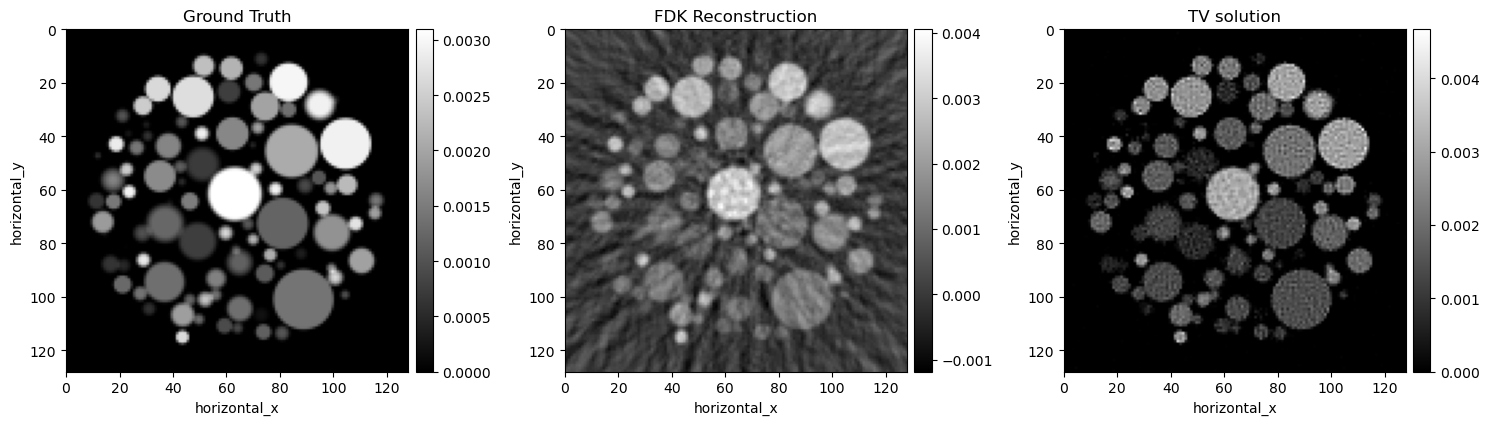

In [19]:
algo=FISTA(initial=ig.allocate(0), f=F, g=G, update_objective_interval=10)
algo.run(500, callbacks=[callbacks.ProgressCallback(), callbacks.TextProgressCallback()])
show2D([ground_truth, recon, algo.solution], title = ['Ground Truth', 'FDK Reconstruction', 'TV solution'], origin = 'upper', num_cols = 3)


In [20]:
algo.run(100, callbacks=[callbacks.ProgressCallback(), callbacks.TextProgressCallback()])

 84%|########3 | 501/600 [00:00<?, ?it/s]

   501/600        ?it/s
   511/600    30.76it/s, objective=+1.011e-01
   521/600    30.74it/s, objective=+1.008e-01
   531/600    30.69it/s, objective=+1.006e-01
   541/600    30.26it/s, objective=+1.004e-01
   551/600    28.95it/s, objective=+1.002e-01
   561/600    20.01it/s, objective=+1.000e-01
   571/600    22.57it/s, objective=+9.986e-02
   581/600    24.69it/s, objective=+9.969e-02
   591/600    26.41it/s, objective=+9.953e-02
   600/600    26.40it/s, objective=+9.938e-02



## Early stopping (a custom callback example)

     0/500        ?it/s
    10/500    31.71it/s, objective=+8.586e+01
    20/500    31.18it/s, objective=+9.047e+00
    30/500    29.77it/s, objective=+2.640e+00
    40/500    30.06it/s, objective=+1.188e+00
    50/500    30.28it/s, objective=+6.928e-01
    60/500    30.35it/s, objective=+4.585e-01
    70/500    30.46it/s, objective=+3.451e-01
    80/500    30.57it/s, objective=+2.741e-01
    90/500    22.27it/s, objective=+2.337e-01
   100/500    22.69it/s, objective=+2.062e-01
   110/500    24.61it/s, objective=+1.870e-01
   110/500    26.86it/s



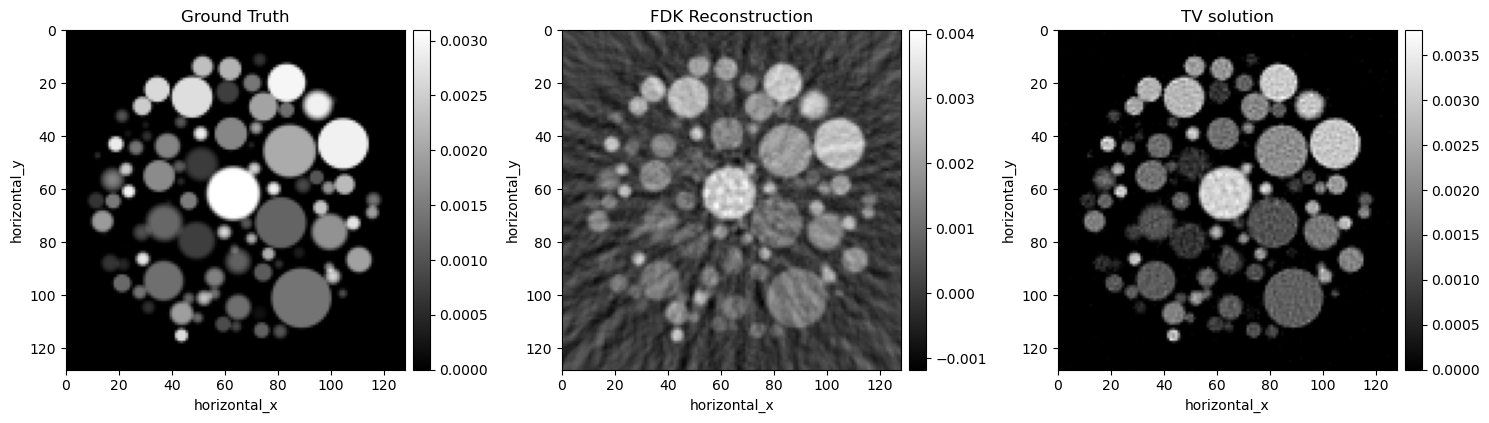

In [21]:
class EarlyStopping(callbacks.Callback):
         def __call__(self, algorithm):
               if algorithm.objective[-1] <= 2e-1:  # arbitrary stopping criterion
                  raise StopIteration

algo=FISTA(initial=ig.allocate(0), f=F, g=G, update_objective_interval=10)         
algo.run(500, callbacks=[callbacks.TextProgressCallback(), EarlyStopping()])
show2D([ground_truth, recon, algo.solution], title = ['Ground Truth', 'FDK Reconstruction', 'TV solution'], origin = 'upper', num_cols = 3)


     0/500        ?it/s
    10/500    23.79it/s, objective=+8.586e+01
    20/500    26.96it/s, objective=+9.047e+00
    23/500    26.89it/s



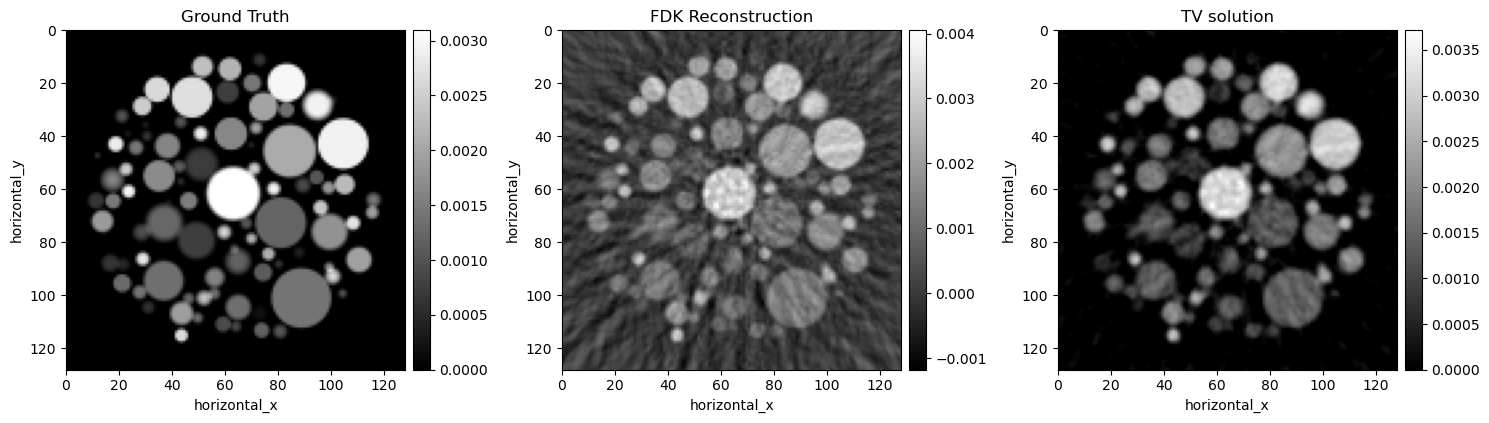

In [22]:
class EarlyStopping(callbacks.Callback):
         def __call__(self, algorithm):
            if np.mean((algorithm.x.array-ground_truth.array)**2) <= 3e-8:  # arbitrary stopping criterion
                  raise StopIteration

algo=FISTA(initial=ig.allocate(0), f=F, g=G, update_objective_interval=10)         
algo.run(500, callbacks=[callbacks.TextProgressCallback(), EarlyStopping()])
show2D([ground_truth, recon, algo.solution], title = ['Ground Truth', 'FDK Reconstruction', 'TV solution'], origin = 'upper', num_cols = 3)

## Calculating data discrepancy at each iteration (A custom callback example) 

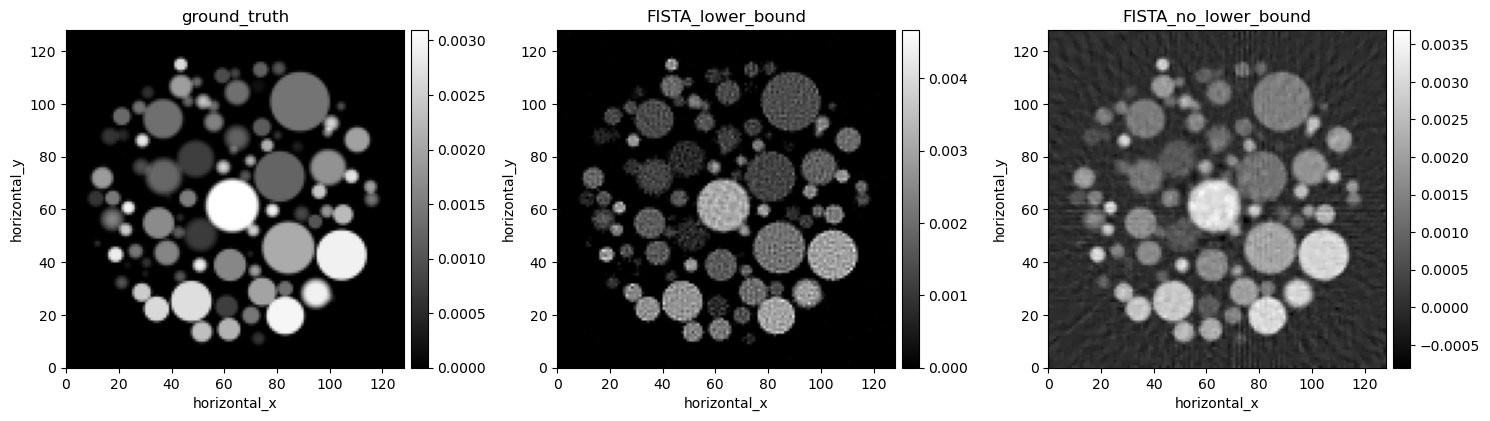

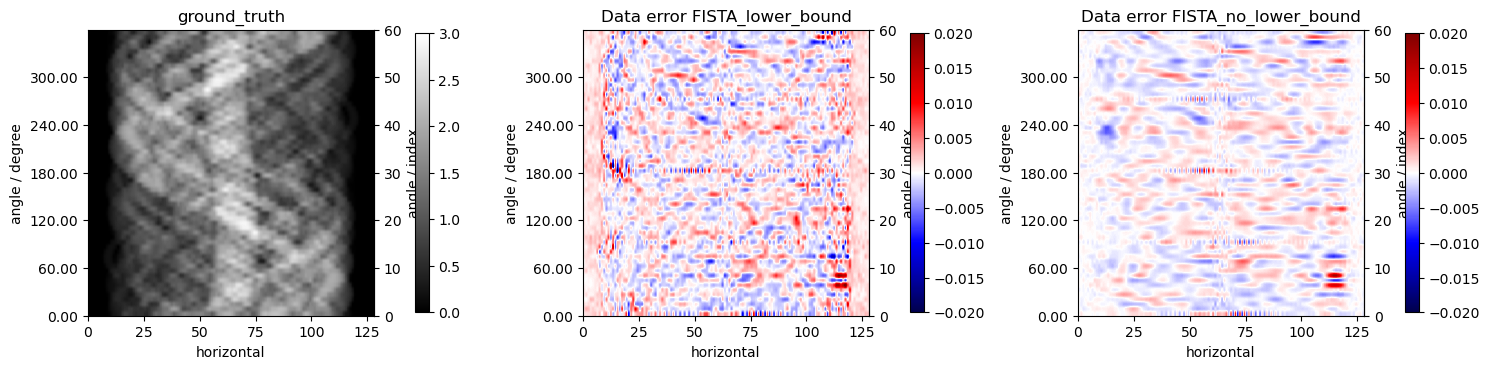

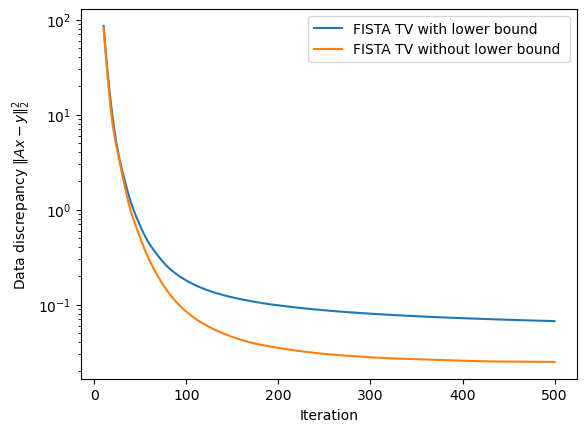

In [23]:
class DataDiscrepancyCallback(callbacks.Callback):
    def __init__(self, A, data):
        self.f = LeastSquares(A, data)
        self.save_values=[]

    def __call__(self, algorithm):
        self.save_values.append(self.f(algorithm.get_output()))

mycallback_FISTA_lower_bound= DataDiscrepancyCallback(A, absorption)
algo1=FISTA(initial=ig.allocate(0), f=F, g=alpha*TotalVariation(lower=0), update_objective_interval=10)         
algo1.run(500, callbacks=[mycallback_FISTA_lower_bound])

        
mycallback_FISTA_no_lower_bound= DataDiscrepancyCallback(A, absorption)
algo2=FISTA(initial=ig.allocate(0), f=F, g=alpha*TotalVariation(), update_objective_interval=10)         
algo2.run(500, callbacks=[mycallback_FISTA_no_lower_bound])


show2D([ground_truth, algo1.get_output(), algo2.get_output()], title=['ground_truth', 'FISTA_lower_bound', 'FISTA_no_lower_bound'], num_cols=3)
show2D([absorption, A.direct(algo1.get_output())-absorption, A.direct(algo2.get_output())-absorption], title=['ground_truth', 'Data error FISTA_lower_bound', 'Data error FISTA_no_lower_bound'], fix_range=[[0,3], [-0.02, 0.02], [-0.02, 0.02]], cmap=['gray', 'seismic', 'seismic'], num_cols=3)
plt.plot(range(10,501), mycallback_FISTA_lower_bound.save_values[10:], label='FISTA TV with lower bound ')
plt.plot(range(10, 501), mycallback_FISTA_no_lower_bound.save_values[10:], label='FISTA TV without lower bound ')
plt.yscale('log')
plt.ylabel('Data discrepancy $\|Ax-y\|_2^2$')
plt.xlabel('Iteration')
plt.legend()

We see that the without the lower bound, the reconstruction overfits to the noisy absorption data 

## Calculating a noise approximation for each iteration  (A custom callback example) 

/home/bih17925/miniconda3/envs/cil_testing2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bih17925/miniconda3/envs/cil_testing2/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


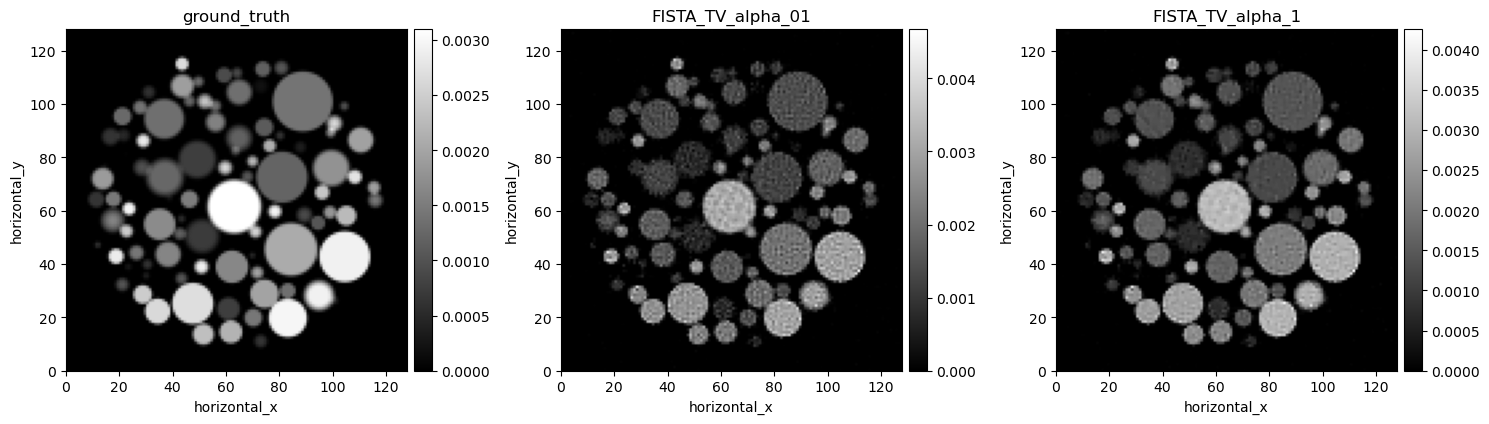

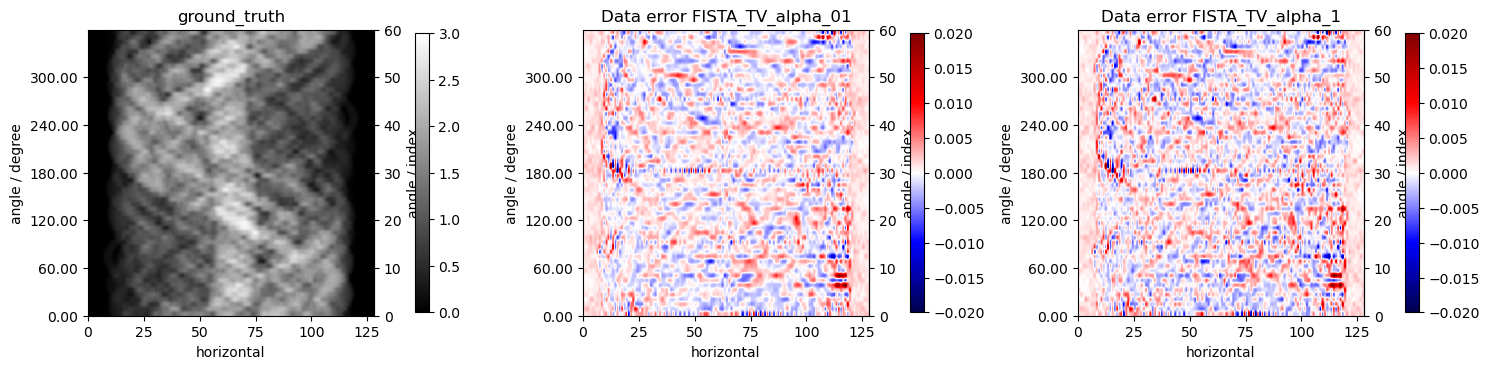

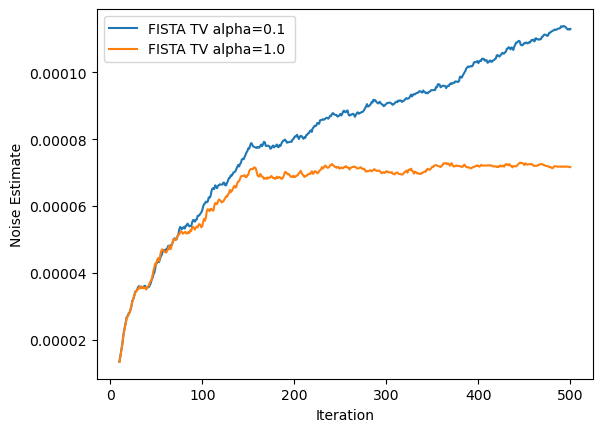

In [24]:
import skimage

class SigmaEstimateCallback(callbacks.Callback):
    def __init__(self):

        self.save_values=[]

    def __call__(self, algorithm):
        self.save_values.append(skimage.restoration.estimate_sigma(algorithm.get_output().as_array()))

mycallback_FISTA_TV_alpha_01= SigmaEstimateCallback()
algo1=FISTA(initial=ig.allocate(0), f=F, g=0.1*TotalVariation(lower=0), update_objective_interval=10)         
algo1.run(500, callbacks=[mycallback_FISTA_TV_alpha_01])

        
mycallback_FISTA_TV_alpha_1= SigmaEstimateCallback()
algo2=FISTA(initial=ig.allocate(0), f=F, g=1*TotalVariation(lower=0), update_objective_interval=10)         
algo2.run(500, callbacks=[mycallback_FISTA_TV_alpha_1])


show2D([ground_truth, algo1.get_output(), algo2.get_output()], title=['ground_truth', 'FISTA_TV_alpha_01', 'FISTA_TV_alpha_1'], num_cols=3)
show2D([absorption, A.direct(algo1.get_output())-absorption, A.direct(algo2.get_output())-absorption], title=['ground_truth', 'Data error FISTA_TV_alpha_01', 'Data error FISTA_TV_alpha_1'], fix_range=[[0,3], [-0.02, 0.02], [-0.02, 0.02]], cmap=['gray', 'seismic', 'seismic'], num_cols=3)
plt.plot(range(10,501), mycallback_FISTA_TV_alpha_01.save_values[10:], label='FISTA TV alpha=0.1 ')
plt.plot(range(10, 501), mycallback_FISTA_TV_alpha_1.save_values[10:], label='FISTA TV alpha=1.0 ')
plt.ylabel('Noise Estimate')
plt.xlabel('Iteration')
plt.legend()
                                   
                            

We see with a larger regularisation parameter, the resulting image is less noisy. 

## Image metric callbacks (custom callback example) 


In [25]:

class MetricsDiagnostics(callbacks.Callback):
    
    def __init__(self, reference_image, metrics_dict, print_interval=1):

        # reference image as numpy (level) array
        self.reference_image = reference_image      
        self.metrics_dict = metrics_dict
        # if data_range is None:
            # self.data_range = np.abs(self.reference_image.max() - self.reference_image.min())
        self.computed_metrics = []    
        self.print_interval=print_interval

        super(MetricsDiagnostics, self).__init__()  

    def __call__(self, algo):

            
        for metric_name, metric_func in self.metrics_dict.items():

            if not hasattr(algo, metric_name):
                setattr(algo, metric_name, [])   
                
            metric_list = getattr(algo, metric_name)
            metric_value = metric_func(self.reference_image, algo.get_output())
            metric_list.append(metric_value)
            
            self.computed_metrics.append(metric_value)
            
        if algo.iteration == 0:
                    
            print (self.callback_header())
        
        print(self.callback_iteration())  
                        
    
            
               
    def callback_header(self):
        return " ".join("{:>20}".format(metric_name) for metric_name in self.metrics_dict.keys())

    def callback_iteration(self):
        if isinstance(self.computed_metrics, list):
            # Handle list of metrics
            return " ".join("{:>20.5e}".format(metric) for metric in self.computed_metrics[-len(self.metrics_dict):])
        else:
            # Handle single metric
            return "{:>20.5e}".format(self.computed_metrics)     
        

from cil.utilities.quality_measures import mae, psnr, mse 
metric_callback= MetricsDiagnostics(ground_truth, {'MSE':mse, 'MAE':mae, 'PSNR':psnr})
algo=FISTA(initial=ig.allocate(0), f=F, g=G, update_objective_interval=10)         
algo.run(100, callbacks=[metric_callback])

                 MSE                  MAE                 PSNR
         1.07888e-06          5.48145e-04          9.48530e+00
         5.85316e-07          6.22034e-04          1.21411e+01
         5.05844e-07          5.72563e-04          1.27749e+01
         4.31374e-07          5.19819e-04          1.34665e+01
         3.64704e-07          4.67054e-04          1.41956e+01
         3.06416e-07          4.16492e-04          1.49519e+01
         2.56388e-07          3.70092e-04          1.57261e+01
         2.14156e-07          3.28810e-04          1.65077e+01
         1.78987e-07          2.92725e-04          1.72868e+01
         1.50022e-07          2.60981e-04          1.80535e+01
         1.26383e-07          2.33361e-04          1.87981e+01
         1.07187e-07          2.09652e-04          1.95136e+01
         9.16141e-08          1.89309e-04          2.01954e+01
         7.89449e-08          1.72049e-04          2.08418e+01
         6.85910e-08          1.57283e-04          2.14

## More complex example, image metric callbacks with region of interests 

Warning - this is a complex example! But the code may be useful to adapt and reuse 

In [26]:
class ImageQualityCallback(callbacks.Callback):
    """
      Parameters
    ----------

    reference_image: CIL or STIR ImageData
      containing the reference image used to calculate the metrics

    roi_mask_dict : dictionary of ImageData objects
      list containing one binary ImageData object for every ROI to be
      evaluated. Voxels with values 1 are considered part of the ROI
      and voxels with value 0 are not.
      Dimension of the ROI mask images must be the same as the dimension of
      the reference image.
      
    metrics_dict : dictionary of lambda functions f(x,y) mapping
      two 1-dimensional numpy arrays x and y to a scalar value or a
      numpy.ndarray.
      x and y can be the voxel values of the whole images or the values of
      voxels in a ROI such that the metric can be computed on the whole
      images and optionally in the ROIs separately.

      E.g. f(x,y) could be MSE(x,y), PSNR(x,y), MAE(x,y)

    statistics_dict : dictionary of lambda functions f(x) mapping a 
      1-dimensional numpy array x to a scalar value or a numpy.ndarray.
      E.g. mean(x), std_deviation(x) that calculate global and / or
      ROI mean and standard deviations.

      E.g. f(x) could be x.mean()




      """
      
    def __init__(self, reference_image, 
                       roi_mask_dict   = None,
                       metrics_dict    = None,
                       statistics_dict = None,
                       ):

        # the reference image
        self.reference_image = reference_image


        self.roi_indices_dict = {}
        self.roi_store=[]



        self.roi_mask_dict=roi_mask_dict
        
        
        self.metrics_dict = metrics_dict
        self.metrics_store={}
        for key, value in self.metrics_dict.items():
                self.metrics_store['global_'+key] = []
                if roi_mask_dict is not None:
                  for roi_name, value in roi_mask_dict.items():
                    self.metrics_store[roi_name+'_'+key] = []

        self.statistics_dict = statistics_dict
        self.stat_store={}
        for key, value in self.statistics_dict.items():
                self.stat_store['global_'+key] = []
                if roi_mask_dict is not None:
                  for roi_name, value in roi_mask_dict.items():
                    self.stat_store[roi_name+'_'+key] = []
                
    def __call__(self, algorithm):
            if self.metrics_dict is not None:
                for metric_name, metric in self.metrics_dict.items():
                    ans = metric(self.reference_image, algorithm.x)
                    self.metrics_store['global_'+metric_name].append(ans)
                    
                    
                    for roi_name, roi in self.roi_mask_dict.items():
                      ans = metric(self.reference_image, algorithm.x, mask=roi)
                      self.metrics_store[roi_name+'_'+metric_name].append(ans)
                       
                    
                    
            if self.statistics_dict is not None:
                for statistic_name, stat in self.statistics_dict.items():
                    ans = stat( algorithm.x.array, np._NoValue)
                    self.stat_store['global_'+statistic_name].append(ans)
                    
                    
                    for roi_name, roi in self.roi_mask_dict.items():
                        ans = stat( algorithm.x.array, roi.array.astype('bool'))
                        self.stat_store[roi_name+'_'+statistic_name].append(ans)
                        
        
                    
                    
       



In [27]:
def mse(dc1, dc2, mask=None):
    ''' Calculates the mean squared error of two images

    Parameters
    ----------
    dc1: `DataContainer`
        One image to be compared
    dc2: `DataContainer`
        Second image to be compared
    mask: array or `DataContainer` with the same dimensions as the `dc1` and `dc2`
        The pixelwise operation only considers values where the mask is True or NonZero.

    Returns
    -------
    A number, the mean squared error of the two images
    '''
    dc1 = dc1.as_array()
    dc2 = dc2.as_array()

    if mask is not None:

        if isinstance(mask, DataContainer):
            mask = mask.as_array()

        mask = mask.astype('bool')
        dc1 = np.extract(mask, dc1)
        dc2 = np.extract(mask, dc2)
    return np.mean(((dc1 - dc2)**2))


def mae(dc1, dc2, mask=None):
    ''' Calculates the Mean Absolute error of two images.

    Parameters
    ----------
    dc1: `DataContainer`
        One image to be compared
    dc2: `DataContainer`
        Second image to be compared
    mask: array or `DataContainer` with the same dimensions as the `dc1` and `dc2`
        The pixelwise operation only considers values where the mask is True or NonZero.


    Returns
    -------
    A number with the mean absolute error between the two images.
    '''
    dc1 = dc1.as_array()
    dc2 = dc2.as_array()

    if mask is not None:

        if isinstance(mask, DataContainer):
            mask = mask.as_array()

        mask = mask.astype('bool')
        dc1 = np.extract(mask, dc1)
        dc2 = np.extract(mask, dc2)

    return np.mean(np.abs((dc1-dc2)))


def psnr(ground_truth, corrupted, mask=None):
    ''' Calculates the Peak signal to noise ratio (PSNR) between the two images.

    Parameters
    ----------
    ground_truth: `DataContainer`
        The reference image
    corrupted: `DataContainer`
        The image to be evaluated
    data_range: scalar value, default=None
        PSNR scaling factor, the dynamic range of the images (i.e., the difference between the maximum the and minimum allowed values). We take the maximum value in the ground truth array.
    mask: array or `DataContainer` with the same dimensions as the `dc1` and `dc2`
        The pixelwise operation only considers values where the mask is True or NonZero..

    Returns
    -------
    A number, the peak signal to noise ration between the two images.
    '''
    

    if mask is None:
        data_range = ground_truth.as_array().max()


    else:

        if isinstance(mask, DataContainer):
            mask = mask.as_array()
        data_range = np.max(ground_truth.as_array(),
                                where=mask.astype('bool'), initial=-1e-8)

    
    tmp_mse = mse(ground_truth, corrupted, mask=mask)

    return 10 * np.log10((data_range ** 2) / tmp_mse)

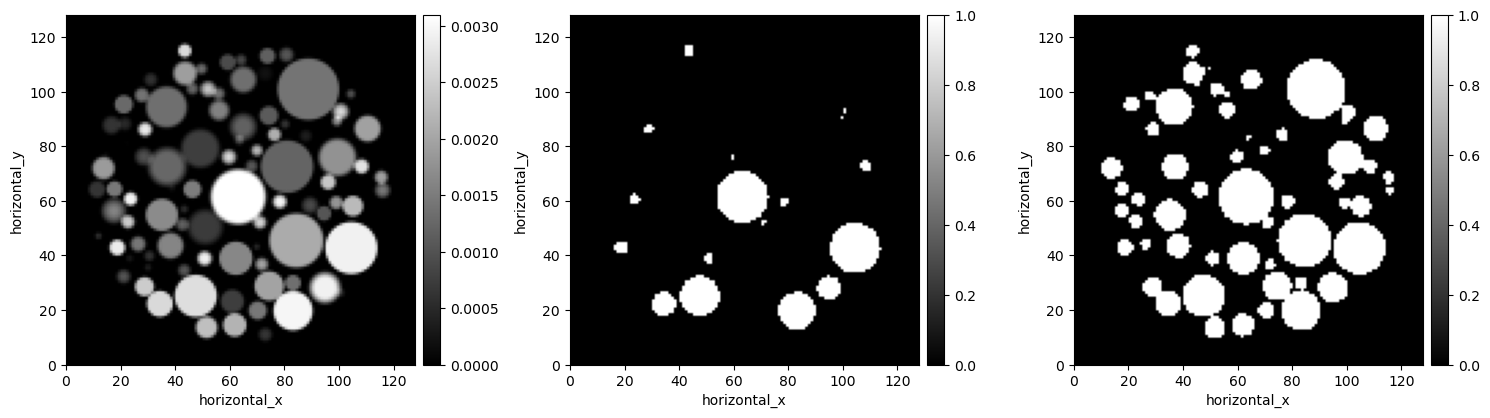

In [28]:
#%% create masks
top = ig.allocate(0)
bottom = ig.allocate(0)

top.fill(
    np.asarray(ground_truth.array > 0.8 * ground_truth.max(), 
               dtype=np.float32)
    )
bottom.fill(
    np.asarray(np.invert(ground_truth.array < 0.4 * ground_truth.max()), 
               dtype=np.float32)
)



roi_image_dict = {
    'top' : top,
    'bottom' : bottom
}

show2D([ground_truth, top, bottom], num_cols=3)

In [29]:
img_qual_callback = ImageQualityCallback(ground_truth,
                                              roi_mask_dict = roi_image_dict,
                                              metrics_dict = {'MSE':mse, 
                                                              'MAE':mae, 
                                                              'PSNR':psnr},
                                              statistics_dict = {'MEAN': (lambda x, y: np.mean(x, where=y)),
                                                                 'STDDEV': (lambda x, y: np.std(x, where=y)),
                                                                 'MAX': (lambda x, y: np.max(x, where=y, initial=0))},
                                              )

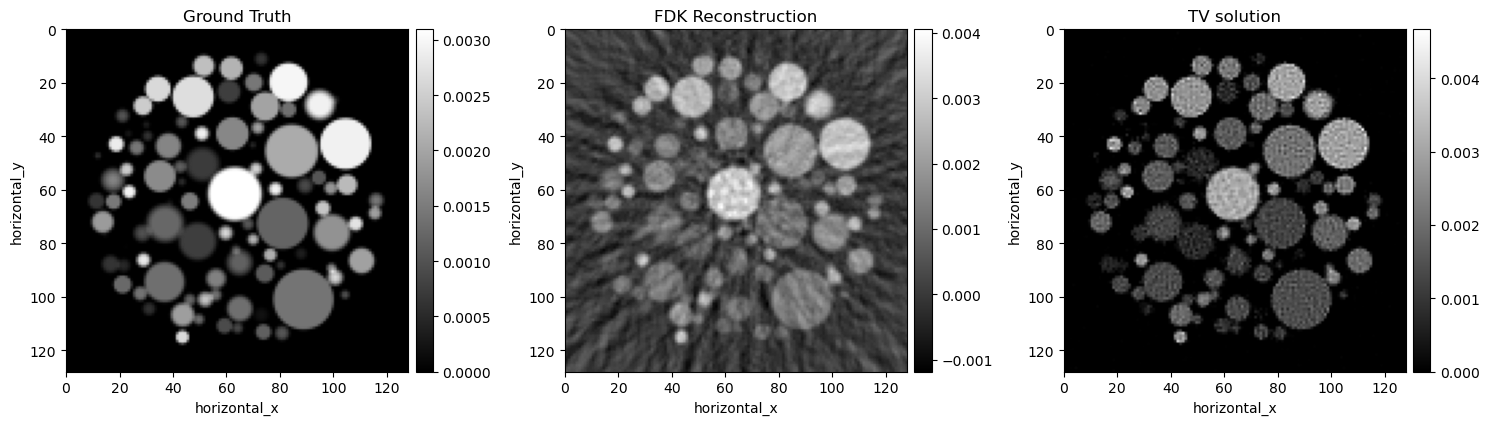

In [30]:
algo=FISTA(initial=ig.allocate(0), f=F, g=G, update_objective_interval=10)         
algo.run(500, callbacks=[img_qual_callback])
show2D([ground_truth, recon, algo.solution], title = ['Ground Truth', 'FDK Reconstruction', 'TV solution'], origin = 'upper', num_cols = 3)

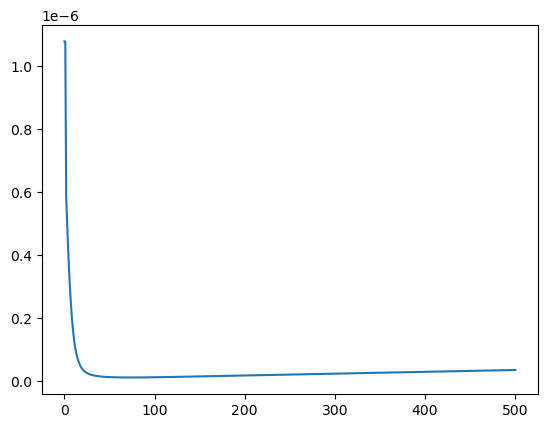

In [31]:
plt.plot(range(501), img_qual_callback.metrics_store['global_MSE'])

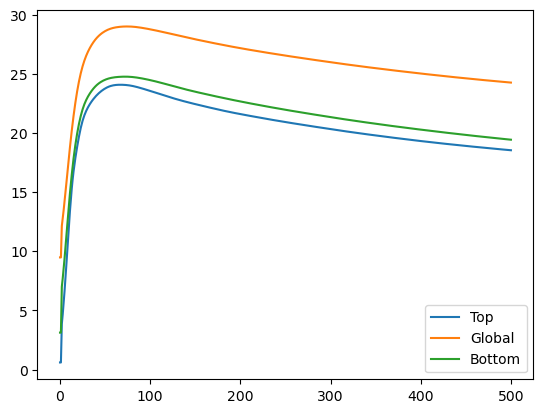

In [32]:
plt.plot(range(501), img_qual_callback.metrics_store['top_PSNR'], label='Top')
plt.plot(range(501), img_qual_callback.metrics_store['global_PSNR'], label='Global')
plt.plot(range(501), img_qual_callback.metrics_store['bottom_PSNR'], label='Bottom')
plt.legend()